# FTTransformer回归任务

本范例演示使用 torchkeras.tabular 中的 FTTransformer 对加州房价数据集 进行回归建模。

公众号**算法美食屋**后台回复关键词：torchkeras，获取本文notebook源码和所用california_housing数据集下载链接。


California_housing数据集使用房屋的以下一些特征:

* 房屋所在街区中位数收入(MedInc)
  
* 房屋年龄(HouseAge)

* 房屋的房间数量(AveRooms)

* 房屋平均每个房间的床数量(AveBedrms)

* 房屋所在地区的人口(Population)

* 房屋所在街区平均家庭人数(AveOccup)

* 房屋位置经度(Longitude)

* 房屋位置纬度(Latitude)


来预测房屋的中位数每平米单价(MedHouseVal)。



In [1]:
import sys
sys.path.append('..')


## 一，准备数据

In [2]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split

file_path = "california_housing.parquet"
dfdata = pd.read_parquet(file_path)

num_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude']
cat_cols = []
target_col = 'MedHouseVal'


print("dfdata.shape = ",dfdata.shape)
print("target_col = ", target_col)
print('cat_cols = ', cat_cols)  
print('num_cols = ', num_cols[:3]+['...'])

dftmp, dftest_raw = train_test_split(dfdata, random_state=42, test_size=0.2)
dftrain_raw, dfval_raw = train_test_split(dftmp, random_state=42, test_size=0.1)

print("len(dftrain) = ",len(dftrain_raw))
print("len(dfval) = ",len(dfval_raw))
print("len(dftest) = ",len(dftest_raw))


dfdata.shape =  (20640, 9)
target_col =  MedHouseVal
cat_cols =  []
num_cols =  ['MedInc', 'HouseAge', 'AveRooms', '...']
len(dftrain) =  14860
len(dfval) =  1652
len(dftest) =  4128


In [3]:
from torchkeras.tabular import TabularPreprocessor
from sklearn.preprocessing import OrdinalEncoder

#特征工程
pipe = TabularPreprocessor(cat_features = cat_cols, 
                           embedding_features=cat_cols)

dftrain = pipe.fit_transform(dftrain_raw.drop(target_col,axis=1))
dftrain[target_col] = dftrain_raw[target_col]

dfval = pipe.transform(dfval_raw.drop(target_col,axis=1))
dfval[target_col] = dfval_raw[target_col]

dftest = pipe.transform(dftest_raw.drop(target_col,axis=1))
dftest[target_col] = dftest_raw[target_col]


In [4]:
from torchkeras.tabular import TabularDataset
from torch.utils.data import Dataset,DataLoader 

def get_dataset(dfdata):
    return TabularDataset(
                data = dfdata,
                task = 'regression', #regression, binary, multiclass
                target = [target_col],
                continuous_cols = pipe.get_numeric_features(),
                categorical_cols = pipe.get_embedding_features()
        )

def get_dataloader(ds,batch_size=1024,num_workers=0,shuffle=False):
    dl = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=False,
        )
    return dl 
    
ds_train = get_dataset(dftrain)
ds_val = get_dataset(dfval)
ds_test = get_dataset(dftest)

dl_train = get_dataloader(ds_train,shuffle=True)
dl_val = get_dataloader(ds_val,shuffle=False)
dl_test = get_dataloader(ds_test,shuffle=False)


In [11]:
for batch in dl_train:
    break
    

In [12]:
batch['id']

tensor([ 5438,  9242,  6999,  ..., 13178,  7561, 14200])

## 二，定义模型

In [40]:
from torchkeras.tabular.models import FTTransformerConfig,FTTransformerModel

model_config = FTTransformerConfig(
    task="regression",  #regression, binary, multiclass
    num_attn_blocks=4
)

config = model_config.merge_dataset_config(ds_train)
net = FTTransformerModel(config = config)

# 考虑到房屋价格总是正的，将模型的Head重置为PoissonHead (激活函数为torch.exp)
# 将模型的 Loss重置为 PoissonLoss 
"""
class PoissonHead(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.linear = nn.Linear(in_features = in_features,out_features=out_features)    
    def forward(self,x):
        return torch.exp(self.linear(x))
    
class PoissonLoss(nn.Module):
    def __init__(self):
        super(PoissonLoss, self).__init__()
        self.loss_fn = nn.PoissonNLLLoss(log_input=False,full=True)

    def forward(self, inputs, targets):
        loss = self.loss_fn(inputs,targets)
        return loss.mean()
    
print(net.backbone.output_dim)
print(net.hparams.output_dim)

net._head  = PoissonHead(in_features=net.backbone.output_dim,
                         out_features=net.hparams.output_dim)
net.loss = PoissonLoss()
"""

net.loss = nn.HuberLoss()


In [41]:
#初始化参数
net.reset_weights()
net.data_aware_initialization(dl_train)

print(net.backbone.output_dim)
print(net.hparams.output_dim)

32
1


In [42]:
output = net.forward(batch)
loss = net.compute_loss(output,batch['target'])
print(loss)


tensor(1.4124, grad_fn=<AddBackward0>)


## 三，训练模型

In [43]:
from torchkeras import KerasModel 
from torchkeras.tabular import StepRunner 
KerasModel.StepRunner = StepRunner 


import torch 
from torchmetrics import MeanAbsoluteError 

keras_model = KerasModel(net,
                   loss_fn=None,
                   optimizer = torch.optim.AdamW(net.parameters(),lr = 3e-4),
                   metrics_dict = {"mae":MeanAbsoluteError()}
                   )

<<<<<< 🚀 mps is used >>>>>>


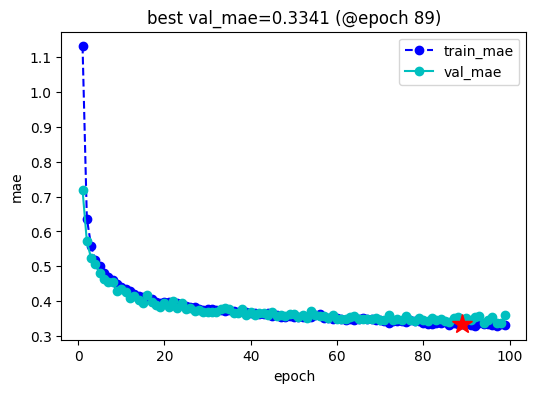

<<<<<< val_mae without improvement in 10 epoch,early stopping >>>>>> 



In [44]:
dfhistory = keras_model.fit(
    train_data = dl_train,
    val_data= dl_val,
    ckpt_path='checkpoint',
    epochs=100,
    patience=10,
    monitor="val_mae", 
    mode="min",
    plot = True,
    wandb = False
)

## 四，评估模型

In [20]:
keras_model.evaluate(dl_train)

100%|████████████████████████████████| 15/15 [00:00<00:00, 29.20it/s, val_loss=0.196, val_mae=0.296]


{'val_loss': 0.19550365308920542, 'val_mae': 0.2955344617366791}

In [21]:
keras_model.evaluate(dl_val)

100%|██████████████████████████████████| 2/2 [00:00<00:00, 15.72it/s, val_loss=0.266, val_mae=0.329]


{'val_loss': 0.26627758145332336, 'val_mae': 0.3290509581565857}

In [22]:
keras_model.evaluate(dl_test)

100%|███████████████████████████████████| 5/5 [00:00<00:00, 25.20it/s, val_loss=0.224, val_mae=0.32]


{'val_loss': 0.22361865341663362, 'val_mae': 0.3199106752872467}

## 五，使用模型

In [23]:
from tqdm.auto import tqdm 

dl_val = keras_model.accelerator.prepare(dl_val)
dl_test = keras_model.accelerator.prepare(dl_test)
net.eval()

def predict(net, dl):
    net.eval() 
    preds = []
    with torch.no_grad():
        for batch in tqdm(dl):
            preds.append(net.predict(batch))
    yhat_list = [yi for yd in preds for yi in yd.cpu()]
    yhat = np.array(yhat_list).reshape(-1,)
    return yhat 
    

def accuracy_score(yhat,y):
    total_diff = np.abs(yhat - y).sum()
    total_gt = y.sum()
    return  1.0  - total_diff/total_gt 

yhat_val = predict(net,dl_val)
yhat_test = predict(net,dl_test)


val_acc = accuracy_score(yhat_val,dfval[target_col])
test_acc = accuracy_score(yhat_test,dftest[target_col])

print('val_acc = ', val_acc)
print('test_acc = ', test_acc)



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

val_acc =  0.843709693736275
test_acc =  0.8443259525697211


In [27]:
from torch import nn 

## 六，保存模型

最佳模型权重已经保存在ckpt_path = 'checkpoint'位置了。

In [ ]:
net.load_state_dict(torch.load('checkpoint',weights_only=True))